<a href="https://colab.research.google.com/github/Xenofon-Chiotopoulos/HPC-Assignments-/blob/main/HPC3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing modules and defining functions that have been taken from the lecture notes

In [ ]:
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix
import numba
from scipy.sparse.linalg import LinearOperator
from numba import cuda
import timeit
import matplotlib.pyplot as plt
import matplotlib

The discretise poisson function will be used in the script for timing comparisons as we can iteratively increace its size

In [ ]:
#Discretise_poisson fucntion to create sparse matrix that we will use
def discretise_poisson(N):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    nelements = 5 * N**2 - 16 * N + 16
    
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    f = np.empty(N * N, dtype=np.float64)
    
    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                f[j * N + i] = 0
                count += 1
                
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i
                                
                data[count] = 4 * (N - 1)**2
                data[count + 1 : count + 5] = - (N - 1)**2
                f[j * N + i] = 1
                
                count += 5
                                                
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f

##Setting up LinearOperator subclass for converting A matrix given in CSR format to Ellpack-R format

This function takes the index matrix elements from CSR and converts it to Ellpack-R. To do this the we input rows and columns indecies, the maximum number of items per row max_rl, the csr data matrix as well as the empty matrices for the attribnutes of Ellpack-R. The empty attributes are .ellpack_data, .ellpack_indecies and .ellpack_rl. The inputes are prepared in the class __init__ function before this function is called inside the class.

In [ ]:
@numba.jit(parallel=True, nopython=True)
def ellpack_prep(col, row, ellpack_data, ellpack_indecies, csr_matrix_data, max_rl):
  count = 1
  for j in numba.prange(len(col)):
    i = j-1
    if count == max_rl:
      count = 0
    if row[i] == row[i-1] or row[i] == row[i+1]:
      ellpack_data[row[i],count] = csr_matrix_data[i]
      count += 1
    else:
      ellpack_data[row[i],0] = csr_matrix_data[i]
      count = 0

  for j in range(len(col)):
    i = j-1
    if count == max_rl:
      count = 0
    if row[i] == row[i-1] or row[i] == row[i+1]:
      ellpack_indecies[row[i],count] = col[i]
      count += 1
    else:
      ellpack_indecies[row[i],0] = col[i]
      count = 0

  return ellpack_data, ellpack_indecies

Defining a LinearOperator subclass which overwrites the @ method to do Ellpack-R matrix multiplication. The __init__ function initially transforms to CSR format to Ellpack-R format so we can the do matrix multiplication. The matrix multiplication works by iterating over the length of the input vector and then iterated over the unique row length in the ellpack_rl vector. Then the result is the sum of vector times the data the the index equal to the dummy variable. 

There is also a numba accelerated version of the matvec method which does not overide the @ function but needs to be called explicitly.

In [ ]:
class EllpackMatrix(LinearOperator):

  def __init__(self,csr_matrix):

    non_zero = csr_matrix.nonzero()
    row = non_zero[0]   # vector of row indecies 
    col = non_zero[1]   # vector of col indecies
    data_index = np.array([row, col])
    uniq_row = np.unique(row, return_counts=True)
    self.ellpack_data = np.zeros(shape=(len(uniq_row[0]),max(uniq_row[1])))   #empty ellpack_data matrix filled with zeros
    self.ellpack_indecies = np.zeros(shape=(len(uniq_row[0]),max(uniq_row[1])))   #empty ellpack_indecies matrix filled with zeros
    
    csr_matrix_data = csr_matrix.data   # csr
    self.ellpack_rl = np.zeros(N*N)
    for i in range(1, len(csr_matrix.indptr)):
      self.ellpack_rl[i-1] = csr_matrix.indptr[i]-csr_matrix.indptr[i-1]
    self.ellpack_rl = self.ellpack_rl.astype('int32')
    max_rl = max(self.ellpack_rl)
    self.shape = (len(self.ellpack_rl),len(self.ellpack_rl))
    self.result  = np.empty(len(self.ellpack_rl))
    self.ellpack_data, self.ellpack_indecies = ellpack_prep(col, row, 
    self.ellpack_data, self.ellpack_indecies, csr_matrix_data, max_rl)
    self.ellpack_indecies = self.ellpack_indecies.astype('int32')
    self.ellpack_rl = self.ellpack_rl.astype('int32')

  def _matvec(self,vec):
    for i in range(len(vec)):
      dummy = 0
      for j in range(self.ellpack_rl[i]):
        dummy += self.ellpack_data[i,j] * vec[int(self.ellpack_indecies[i,j])]
      self.result[i] = dummy
    return self.result

  @staticmethod
  @numba.jit(parallel=True, nopython=True)
  def matvec_numba(ellpack_rl,ellpack_data,ellpack_indecies,result,vec):
      for i in numba.prange(len(vec)):
        dummy = 0
        for j in range(ellpack_rl[i]):
          dummy += ellpack_data[i,j] * vec[int(ellpack_indecies[i,j])]
        result[i] = dummy
      return result

debugging test numba function to test that the result of the class function matvec_numba is equal to the function called outside the class to make sure the @staticmethod works properly

In [ ]:
@numba.jit(parallel=True, nopython=True)
def matvec(ellpack_rl,ellpack_data,ellpack_indecies,result,vec):
    for i in numba.prange(len(vec)):
      dummy = 0
      for j in range(ellpack_rl[i]):
        dummy += ellpack_data[i,j] * vec[int(ellpack_indecies[i,j])]
      result[i] = dummy
    return result

Initilizing the CSR and Ellpack-R objects using the discretise poisson function to check that both methods inside and outside the class work properly

In [ ]:
N=3
A, _ = discretise_poisson(N)
my_sparse_mat = EllpackMatrix(A)

Creating a random matrix and then doing one matrix multiplication for the random matrix against our initialized CSR and Ellpack_R objects

In [ ]:
x = np.random.randn(my_sparse_mat.shape[1])
z = my_sparse_mat @ x
numba_test = matvec(my_sparse_mat.ellpack_rl,my_sparse_mat.ellpack_data,
                    my_sparse_mat.ellpack_indecies,my_sparse_mat.result,x)
r = my_sparse_mat.matvec_numba(my_sparse_mat.ellpack_rl,
my_sparse_mat.ellpack_data,my_sparse_mat.ellpack_indecies,my_sparse_mat.result,x)
scipy = A @ x

Cell that uses the error function found in lecture to check the all the methods produce the correct results, as we can see the error is 0.0 for all the methods indicating that our functions are working correctly.

In [ ]:
rel_error_1 = np.linalg.norm(z - scipy, np.inf) / np.linalg.norm(scipy, np.inf)
print(rel_error_1)
rel_error_2 = np.linalg.norm(numba_test - scipy, np.inf) / np.linalg.norm(scipy, np.inf)
print(rel_error_2)
rel_error_3 = np.linalg.norm(r - scipy, np.inf) / np.linalg.norm(scipy, np.inf)
print(rel_error_3)

0.0
0.0
0.0


Some test timing results to see how quick our different functions are. We can see that the numba method accelerates the run time beating Scipy for this matrix. And the not jit complied matvec method being the slowest. The matvec method that is inside the class is always slightly slower than the one outside the class not this difference is negligable. 

In [ ]:
a = %timeit -o my_sparse_mat.matvec_numba(my_sparse_mat.ellpack_rl,
my_sparse_mat.ellpack_data,my_sparse_mat.ellpack_indecies,my_sparse_mat.result,x)
b = %timeit -o matvec(my_sparse_mat.ellpack_rl,my_sparse_mat.ellpack_data,
                      my_sparse_mat.ellpack_indecies,my_sparse_mat.result,x)
c = %timeit -o my_sparse_mat @ x
d = %timeit -o A @ x

The slowest run took 199.25 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 3.81 µs per loop
The slowest run took 4.36 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 3.59 µs per loop
The slowest run took 4.26 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 21.9 µs per loop
The slowest run took 8.75 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 5.4 µs per loop


As a convention the matvec defined outside the class will be used as the one inside the class can cause some runtime errors due to jit compling inside a class, which is not recomended.

## GPU matvec implementation

In the following block we define our kernal that will be used inside the gpu to preform matvec multiplication.  

In [ ]:
threadsperblock = 512
blockspergrid = (len(x) + (threadsperblock - 1)) // threadsperblock
output = np.zeros(my_sparse_mat.ellpack_rl.shape[0], dtype=np.float32)
@cuda.jit()
def gpu_matvec(my_sparse_mat_d, my_sparse_mat_i, my_sparse_mat_rl, vec, output):
  i = cuda.grid(1)
  if i < vec.shape[0]:
    tmp = 0.
    for j in range(my_sparse_mat_rl[i]):
        tmp += my_sparse_mat_d[i, j] * vec[int(my_sparse_mat_i[i, j])]
    output[i] = tmp

This function first defines all the arrays needed to run gpu_matvec and then sends them to the gpu device. Once the kernal has run it times it and then returns the output array and the time taken to run the entire function.

In [ ]:
def run_kernal(my_sparse_mat, x):
  my_sparse_mat.ellpack_data = my_sparse_mat.ellpack_data.astype('float64')
  my_sparse_mat.ellpack_indecies = my_sparse_mat.ellpack_indecies.astype('float64')
  my_sparse_mat.ellpack_rl = my_sparse_mat.ellpack_rl.astype('int32')
  x = x.astype('float64')
  local_d = cuda.to_device(my_sparse_mat.ellpack_data)
  local_i = cuda.to_device(my_sparse_mat.ellpack_indecies)
  local_rl = cuda.to_device(my_sparse_mat.ellpack_rl)
  local_vec = cuda.to_device(x)
  output = np.empty_like(local_vec)
  local_output = cuda.to_device(output)


  gpu_matvec[(blockspergrid,1),(threadsperblock,1)](local_d, local_i, 
                                              local_rl, local_vec, local_output)
  a = %timeit -o gpu_matvec[(blockspergrid,1),(threadsperblock,1)](local_d, 
                                     local_i, local_rl, local_vec, local_output)

  arr = np.empty(shape=output.shape, dtype = output.dtype)
  local_output.copy_to_host(arr)
  local_output = arr
  return local_output, a

Here we have a test initialisation for the poisson fucntion to see if the implementation works.

In [ ]:
N=1000
A, _ = discretise_poisson(N)
my_sparse_mat= EllpackMatrix(A)
x = np.random.randn(my_sparse_mat.shape[0])
scipy = A @ x

Here we initialise all the arrays that need to be sent to the gpu, as the run_kernal def will not work without the initialsed arrays.

In [ ]:
my_sparse_mat.ellpack_data = my_sparse_mat.ellpack_data.astype('float64')
my_sparse_mat.ellpack_indecies = my_sparse_mat.ellpack_indecies.astype('float64')
my_sparse_mat.ellpack_rl = my_sparse_mat.ellpack_rl.astype('float64')
x = x.astype('float64')
local_d = cuda.to_device(my_sparse_mat.ellpack_data)
local_i = cuda.to_device(my_sparse_mat.ellpack_indecies)
local_rl = cuda.to_device(my_sparse_mat.ellpack_rl)
local_vec = cuda.to_device(x)
output = np.empty_like(local_vec)
local_output = cuda.to_device(output)


gpu_matvec[(blockspergrid,1),(threadsperblock,1)](local_d, local_i, local_rl,
                                                  local_vec, local_output)
run_time = %timeit gpu_matvec[(blockspergrid,1),(threadsperblock,1)](local_d, 
                                      local_i, local_rl, local_vec, local_output)

arr = np.empty(shape=output.shape, dtype = output.dtype)
local_output.copy_to_host(arr)
local_output = arr

1000 loops, best of 5: 248 µs per loop


From the results below we can see that the implementation works for a poisson function of $N = 1000$ with machine precision error. A key thing to not is that the time taken is $4.51 ms$ for the function below and only $245 \mu s$. This is becuase the timeit object above only times the kernal time and the one below times the arrays being sent to the gpu and being sent back to the host machine. 

In [ ]:
local_output, run_time = run_kernal(my_sparse_mat,x)
scipy = A @ x
rel_error_gpu = np.linalg.norm(local_output - scipy, np.inf) / np.linalg.norm(scipy, np.inf)
print(rel_error_gpu)

The slowest run took 37.96 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 5: 4.51 ms per loop
3.1860852462488297e-16


##Testing random matrices

Here we redefine the Class as the one above is specialised for the poisson fucntion and not for any general random matrix. This class can handle any matrix.

In [ ]:
class EllpackMatrix_test(LinearOperator):

  def __init__(self,csr_matrix):

    non_zero = csr_matrix.nonzero()
    row = non_zero[0]
    col = non_zero[1]
    data_index = np.array([row, col])
    uniq_row = np.unique(row, return_counts=True)
    self.ellpack_data = np.zeros(shape=(len(uniq_row[0]),max(row)))
    self.ellpack_indecies = np.zeros(shape=(len(uniq_row[0]),max(row)))
    csr_matrix_data = csr_matrix.data
    self.ellpack_rl = np.zeros(N)
    for i in range(1, len(csr_matrix.indptr)):
      self.ellpack_rl[i-1] = csr_matrix.indptr[i]-csr_matrix.indptr[i-1]
    self.ellpack_rl = self.ellpack_rl.astype('int32')
    max_rl = max(self.ellpack_rl)
    self.shape = (len(self.ellpack_rl),len(self.ellpack_rl))
    self.result  = np.empty(len(self.ellpack_rl))
  
    self.ellpack_indecies = self.ellpack_indecies.astype('int32')
    self.ellpack_rl = self.ellpack_rl.astype('int32')
    

    count = 0
    for j in range(max(row)-1):
      for i in range(self.ellpack_rl[j]):
        self.ellpack_indecies[j,i] = col[count]
        self.ellpack_data[j,i] = csr_matrix.data[count]
        count += 1


    self.ellpack_indecies = self.ellpack_indecies.astype('int32')
    self.ellpack_rl = self.ellpack_rl.astype('int32') 
    

  def _matvec(self,vec):
    for i in range(len(vec)):
      dummy = 0
      for j in range(self.ellpack_rl[i]):
        dummy += self.ellpack_data[i,j] * vec[int(self.ellpack_indecies[i,j])]
      self.result[i] = dummy
    return self.result

  @staticmethod
  @numba.jit(parallel=True, nopython=True)
  def matvec_numba(ellpack_rl,ellpack_data,ellpack_indecies,result,vec):
      for i in numba.prange(len(vec)):
        dummy = 0
        for j in range(ellpack_rl[i]):
          dummy += ellpack_data[i,j] * vec[int(ellpack_indecies[i,j])]
        result[i] = dummy
      return result

Here we create a random sparse matrix of size $1000\times1000$

In [ ]:
from scipy.sparse import random
sparse = random(1000, 1000, density=0.01, format='csr')

Creating our Ellpack_R object, and defining the size of the matrix.

In [ ]:
N = 1000
my_sparse_mat_test = EllpackMatrix_test(sparse)

Creating our 3 random vectors that will be used to test the error that our fucntions produce relative to CSR matrix multiplication from scipy.sparse.linalg.LinearOperator.

In [ ]:
x_1 = np.random.randn(my_sparse_mat_test.shape[1])
x_2 = np.random.randn(my_sparse_mat_test.shape[1])
x_3 = np.random.randn(my_sparse_mat_test.shape[1])

Testing random vector 1 for scipy against numba produces 0 error.

In [ ]:
scipy_1 = sparse @ x_1
Ellpack_1 = my_sparse_mat_test.matvec(x_1)
rel_error_1 = np.linalg.norm(Ellpack_1 - scipy_1, np.inf) / np.linalg.norm(scipy_1, np.inf)
print(rel_error_1)

0.0


Testing random vector 2 for scipy against numba produces 0 error.

In [ ]:
scipy_2 = sparse @ x_2
Ellpack_2 = my_sparse_mat_test.matvec(x_2)
rel_error_2 = np.linalg.norm(Ellpack_2 - scipy_2, np.inf) / np.linalg.norm(scipy_2, np.inf)
print(rel_error_2)

0.0


Testing random vector 3 for scipy against numba produces 0 error.

In [ ]:
scipy_3 = sparse @ x_3
Ellpack_3 = my_sparse_mat_test.matvec(x_3)
rel_error_3 = np.linalg.norm(Ellpack_3 - scipy_3, np.inf) / np.linalg.norm(scipy_3, np.inf)
print(rel_error_3)

0.0


Testing random vector 1 for scipy against Cpu implementation produces 0 error.

In [ ]:
#placeholder
|
|
|
#placeholder

In [ ]:
scipy_1 = sparse @ x_1
Ellpack_1 = matvec(my_sparse_mat_test.ellpack_rl,my_sparse_mat_test.ellpack_data,
            my_sparse_mat_test.ellpack_indecies, my_sparse_mat_test.result, x_1)
rel_error_1 = np.linalg.norm(Ellpack_1 - scipy_1, np.inf) / np.linalg.norm(scipy_1, np.inf)
print(rel_error_1)

0.0


Testing random vector 2 for scipy against Cpu implementation produces 0 error.

In [ ]:
scipy_2 = sparse @ x_2
Ellpack_2 = matvec(my_sparse_mat_test.ellpack_rl,my_sparse_mat_test.ellpack_data,
            my_sparse_mat_test.ellpack_indecies, my_sparse_mat_test.result, x_2)
rel_error_2 = np.linalg.norm(Ellpack_2 - scipy_2, np.inf) / np.linalg.norm(scipy_2, np.inf)
print(rel_error_2)

0.0


Testing random vector 3 for scipy against Cpu implementation produces 0 error.

In [ ]:
scipy_3 = sparse @ x_3
Ellpack_3 = matvec(my_sparse_mat_test.ellpack_rl,my_sparse_mat_test.ellpack_data,
            my_sparse_mat_test.ellpack_indecies, my_sparse_mat_test.result, x_3)
rel_error_3 = np.linalg.norm(Ellpack_3 - scipy_3, np.inf) / np.linalg.norm(scipy_3, np.inf)
print(rel_error_3)

0.0


Testing random vector 1 for scipy against Gpu implementation produces error at machine precision.

In [ ]:
scipy_1 = sparse @ x_1
gpu_Ellpack_1, run_time = run_kernal(my_sparse_mat_test,x_1)
rel_error_1 = np.linalg.norm(gpu_Ellpack_1 - scipy_1, np.inf) / np.linalg.norm(scipy_1, np.inf)
print(rel_error_1)

The slowest run took 25.93 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 5: 4.55 ms per loop
5.48111488333316e-16


Testing random vector 2 for scipy against Gpu implementation produces error at machine precision.

In [ ]:
scipy_2 = sparse @ x_2
gpu_Ellpack_2, run_time = run_kernal(my_sparse_mat_test,x_2)
rel_error_2 = np.linalg.norm(gpu_Ellpack_2 - scipy_2, np.inf) / np.linalg.norm(scipy_2, np.inf)
print(rel_error_2)

100 loops, best of 5: 4.57 ms per loop
5.054931455190615e-16


Testing random vector 3 for scipy against Gpu implementation produces error at machine precision.

In [ ]:
scipy_3 = sparse @ x_3
gpu_Ellpack_3, run_time = run_kernal(my_sparse_mat_test,x_3)
rel_error_3 = np.linalg.norm(gpu_Ellpack_3 - scipy_3, np.inf) / np.linalg.norm(scipy_3, np.inf)
print(rel_error_3)

100 loops, best of 5: 4.65 ms per loop
4.605680093057884e-16


From the above testing we can see that all our methods work properly with the error either being 0 or in the order of machine precision.

## Creating timing and error graphs

The following cell cointatins a for loop for changing N where the size of the matrix is $(N\times N,N\times N)$. We chose to iterate upto $N = 2000$ as when we have very large matrices we see some peculiar behaviour in the GPU. We store the time taken for the matrix vector multiplication for the CPU method, CPU numba method, GPU method and the Scipy CSR matvec method.

In [ ]:
plot_list_scipy = []
plot_list_cpu = []
plot_list_gpu = []
plot_list_gpu_f = []
plot_list = []
for N in range(100,2100,100):
  my_sparse_mat.ellpack_data = my_sparse_mat.ellpack_data.astype('float64')
  my_sparse_mat.ellpack_indecies = my_sparse_mat.ellpack_indecies.astype('float64')
  my_sparse_mat.ellpack_rl = my_sparse_mat.ellpack_rl.astype('float64')
  x = x.astype('float64')
  local_d = cuda.to_device(my_sparse_mat.ellpack_data)
  local_i = cuda.to_device(my_sparse_mat.ellpack_indecies)
  local_rl = cuda.to_device(my_sparse_mat.ellpack_rl)
  local_vec = cuda.to_device(x)
  output = np.empty_like(local_vec)
  local_output = cuda.to_device(output)



  A, _ = discretise_poisson(N)
  my_sparse_mat = EllpackMatrix(A)
  x = np.random.randn(my_sparse_mat.shape[1])
  #Each matvec method

  gpu_matvec[(blockspergrid,1),(threadsperblock,1)](local_d, local_i, local_rl,
                                                    local_vec, local_output)
  run_time = %timeit -o gpu_matvec[(blockspergrid,1),(threadsperblock,1)](local_d, 
                                    local_i, local_rl, local_vec, local_output)
  numba = my_sparse_mat.matvec_numba(my_sparse_mat.ellpack_rl,my_sparse_mat.ellpack_data,
                                    my_sparse_mat.ellpack_indecies,my_sparse_mat.result,x)
  scipy = A @ x
  #std = %timeit -o my_sparse_mat @ x
  c = %timeit -o A @ x
  a = %timeit -o my_sparse_mat.matvec_numba(my_sparse_mat.ellpack_rl,
  my_sparse_mat.ellpack_data,my_sparse_mat.ellpack_indecies,my_sparse_mat.result,x)
  

  #plot_list.append(std.best)
  plot_list_gpu.append(run_time.best)
  plot_list_cpu.append(a.best)
  plot_list_scipy.append(c.best)


This loop is the same as the one above but for the error between the GPU and Scipy CSR matvec for different N. The other methods were not tracked as I found the error is always 0.0 .

In [ ]:
for N in range(10,1100,100):
  A, _ = discretise_poisson(N)
  my_sparse_mat = EllpackMatrix(A)
  x = np.random.randn(my_sparse_mat.shape[1])
  i = int((N-10)/100)

  local_output1, run_time1 = run_kernal(my_sparse_mat,x)
  local_output, run_time = run_kernal(my_sparse_mat,x)
  scipy = A @ x
  rel_error_gpu = np.linalg.norm(local_output - scipy, np.inf) / np.linalg.norm(scipy, 
                                                                                np.inf)
  error_list[i] = rel_error_gpu

This cell converts the times list and error list to numpy arrays.

In [ ]:
plot_list_scipy = np.array(plot_list_scipy)
plot_list = np.array(plot_list)
plot_list_cpu = np.array(plot_list_cpu)
plot_list_gpu = np.array(plot_list_gpu)
plot_list_gpu_f = np.array(plot_list_gpu_f)
list = np.array(list)
error_list_gpu = np.zeros_like(plot_list_gpu)
x_axis = np.arange(100,2100,100)
for i in range(len(x_axis)):
  x_axis[i] = x_axis[i]*x_axis[i]

This graph shows the amount of time taken to complete one matvec multiplication for different size matrices. The naive CPU Ellpack_R implementation is so much slower than the rest the we disgard it to see the behaviour of the other methods.

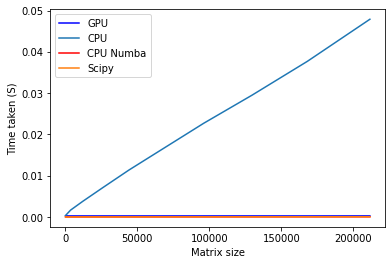

In [ ]:
plt.plot(x_axis, plot_list_gpu, label = 'GPU', color='b')
plt.plot(x_axis, plot_list, label = 'CPU')
plt.plot(x_axis, plot_list_cpu, label = 'CPU Numba', color='r')
plt.plot(x_axis, plot_list_scipy, label = 'Scipy')
plt.xlabel('Matrix size')
plt.ylabel('Time taken (S)')
plt.legend()
plt.show()

This graph shows numba vs GPU vs Scipy. From this graph we can see that Scipy is the slowest of all the methods for large N, with the CPU implentation coming next and the GPU being the fastest. This makes sense as the GPU parallisation allows for all the calculations to be done at once. The time taken stays relatively similar all the way through for the GPU as increacing the size of the matrix simply makes the GPU use more threads and so the time taken should not deviate very much. The gpu here seems to be far better than any other method however the timing does not take into account the fact that the arrays need to be send to the gpu and then sent back to the host, this process takes some time and acts as a bottleneck on how fast the gpu computation can be performed.

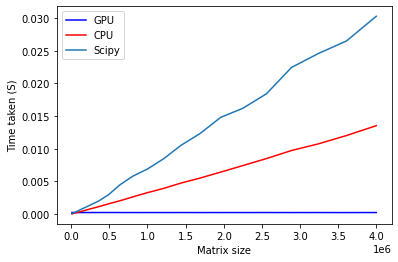

In [ ]:
plt.plot(x_axis, plot_list_gpu, label = 'GPU', color='b')
plt.plot(x_axis, plot_list_cpu, label = 'CPU', color='r')
plt.plot(x_axis, plot_list_scipy, label = 'Scipy')
plt.xlabel('Matrix size')
plt.ylabel('Time taken (S)')
plt.legend()
plt.show()

The following graph shows the change in time taken for the gpu function with increasing N. We can see that the change in time taken seems to be random. However the change is almost constant as increace in N simply means the gpu uses more threads to do calculations however they still all happen at the same time.

In [ ]:
#placment 
|
|
|
|
|
|
|
|
|
#placment

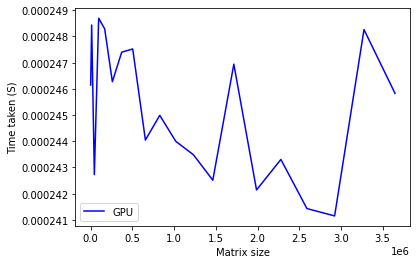

In [ ]:
plt.plot(x_axis, plot_list_gpu, label = 'GPU', color='b')
plt.xlabel('Matrix size')
plt.ylabel('Time taken (S)')
plt.legend()
plt.show()

One very interesting result to look at is the time taken for all three methods for small matrices. As in this case we can see that the gpu does not perform as well as the other methods. This is because the gpu has a certain overhead that is greater than that of Scipy and the numba cpu functions.

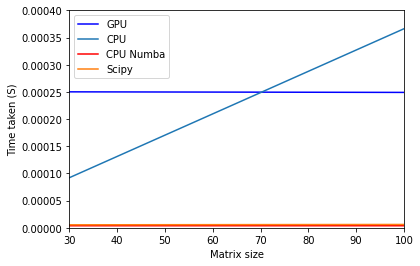

In [ ]:
plt.plot(x_axis, plot_list_gpu, label = 'GPU', color='b')
plt.plot(x_axis, plot_list, label = 'CPU')
plt.plot(x_axis, plot_list_cpu, label = 'CPU Numba', color='r')
plt.plot(x_axis, plot_list_scipy, label = 'Scipy')
plt.xlabel('Matrix size')
plt.ylabel('Time taken (S)')
plt.ylim([0,0.0004])
plt.xlim([30,100])
plt.legend()
plt.show()

The error is of machine precision all the way through the iterations for the gpu

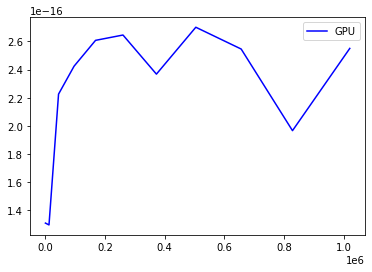

In [ ]:
plt.plot(x_axis, list, label = 'GPU', color='b')
plt.legend()
plt.show()

##reading matrix in

In [ ]:
from scipy.io import mmread

Reading in the matrix from matrix market

In [ ]:
test_matrix_1 = mmread('/content/bcsstm25.mtx.gz')
test_matrix_2 = mmread('/content/fidap011.mtx.gz')

Converting the matrices to CSR format

In [ ]:
test_matrix_1_csr = test_matrix_1.tocsr()
test_matrix_2_csr = test_matrix_2.tocsr()

Looking at the shapes

In [ ]:
print(test_matrix_1_csr.shape)
print(test_matrix_2_csr.shape)

(15439, 15439)
(16614, 16614)


Creating the Ellpack-R object, the random vector to test with, and running the Scipy, cpu and gpu methods. For matrix 1.

In [ ]:
N = test_matrix_1_csr.shape[0]
my_sparse_mat_test = EllpackMatrix_test(test_matrix_1_csr)
rand_mat = np.random.randn(my_sparse_mat_test.shape[1])
standard_result = test_matrix_1 @ rand_mat
numba_result = my_sparse_mat_test.matvec_numba(my_sparse_mat_test.ellpack_rl,
my_sparse_mat_test.ellpack_data, my_sparse_mat_test.ellpack_indecies, 
my_sparse_mat_test.result, rand_mat)
local_output, run_time = run_kernal(my_sparse_mat_test,rand_mat)

Timing the methods




In [ ]:
%timeit -o test_matrix_1 @ rand_mat
%timeit -o matvec(my_sparse_mat_test.ellpack_rl,my_sparse_mat_test.ellpack_data, 
       my_sparse_mat_test.ellpack_indecies, my_sparse_mat_test.result, rand_mat)

The slowest run took 22.63 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 24.9 µs per loop
The slowest run took 1476.77 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 287 µs per loop


<TimeitResult : 1 loop, best of 5: 287 µs per loop>

In [ ]:
my_sparse_mat_test.ellpack_data = my_sparse_mat_test.ellpack_data.astype('float64')
my_sparse_mat_test.ellpack_indecies = my_sparse_mat_test.ellpack_indecies.astype('float64')
my_sparse_mat_test.ellpack_rl = my_sparse_mat_test.ellpack_rl.astype('float64')
x = x.astype('float64')
local_d = cuda.to_device(my_sparse_mat_test.ellpack_data)
local_i = cuda.to_device(my_sparse_mat_test.ellpack_indecies)
local_rl = cuda.to_device(my_sparse_mat_test.ellpack_rl)
local_vec = cuda.to_device(rand_mat)
output = np.empty_like(local_vec)
local_output = cuda.to_device(output)
gpu_matvec[(blockspergrid,1),(threadsperblock,1)](local_d, local_i, local_rl, 
                                                  local_vec, local_output)
a = %timeit -o gpu_matvec[(blockspergrid,1),(threadsperblock,1)](local_d, local_i,
                                                local_rl, local_vec, local_output)

arr = np.empty(shape=output.shape, dtype = output.dtype)
local_output.copy_to_host(arr)
local_output = arr

1000 loops, best of 5: 247 µs per loop


We can see that for this matrix bcsstm25 which is a very sparse matrix with low density and 1 element per row the csr matvec outperforms the Ellpack-R version, this is because when there is only 1 element per row CSR is just as compact as ellpack and uniform, and we are testing the baseline speed of my methods against that of Scipy which is clearly faster. 

Creating the Ellpack-R object, the random vector to test with, and running the Scipy, cpu and gpu methods. For matrix 2.

In [ ]:
N = test_matrix_2_csr.shape[0]
my_sparse_mat_test = EllpackMatrix_test(test_matrix_2_csr)
rand_mat = np.random.randn(my_sparse_mat_test.shape[1])
standard_result = test_matrix_2 @ rand_mat
numba_result = my_sparse_mat_test.matvec_numba(my_sparse_mat_test.ellpack_rl,
my_sparse_mat_test.ellpack_data, my_sparse_mat_test.ellpack_indecies, 
my_sparse_mat_test.result, rand_mat)
local_output, run_time = run_kernal(my_sparse_mat_test,rand_mat)

Timing the methods


In [ ]:
%timeit -o test_matrix_2 @ rand_mat
%timeit -o my_sparse_mat_test.matvec_numba(my_sparse_mat_test.ellpack_rl,
my_sparse_mat_test.ellpack_data, my_sparse_mat_test.ellpack_indecies, 
my_sparse_mat_test.result, rand_mat)

1000 loops, best of 5: 1.08 ms per loop
1000 loops, best of 5: 1.22 ms per loop


<TimeitResult : 1000 loops, best of 5: 1.22 ms per loop>

In [ ]:
my_sparse_mat_test.ellpack_data = my_sparse_mat_test.ellpack_data.astype('float64')
my_sparse_mat_test.ellpack_indecies = my_sparse_mat_test.ellpack_indecies.astype('float64')
my_sparse_mat_test.ellpack_rl = my_sparse_mat_test.ellpack_rl.astype('float64')
x = x.astype('float64')
local_d = cuda.to_device(my_sparse_mat_test.ellpack_data)
local_i = cuda.to_device(my_sparse_mat_test.ellpack_indecies)
local_rl = cuda.to_device(my_sparse_mat_test.ellpack_rl)
local_vec = cuda.to_device(rand_mat)
output = np.empty_like(local_vec)
local_output = cuda.to_device(output)
gpu_matvec[(blockspergrid,1),(threadsperblock,1)](local_d, local_i, local_rl, 
                                                  local_vec, local_output)
a = %timeit -o gpu_matvec[(blockspergrid,1),(threadsperblock,1)](local_d, local_i,
                                                local_rl, local_vec, local_output)

arr = np.empty(shape=output.shape, dtype = output.dtype)
local_output.copy_to_host(arr)
local_output = arr

1000 loops, best of 5: 244 µs per loop


We can see that for this matrix FIDAP011 the gpu clearly out performs the CSR and the cpu methods, this is a large matrix with high number of elements per row but not a crazy standard deviation making it a good candidate for Ellpack-R.

##Section 4

In [ ]:
threadsperblock = 16
blockspergrid = (len(x) + (threadsperblock - 1)) // threadsperblock
output = np.zeros(my_sparse_mat.ellpack_rl.shape[0], dtype=np.float32)
@cuda.jit()
def gpu_matvec_fast(my_sparse_mat_d, my_sparse_mat_i, my_sparse_mat_rl, vec, output):
  local_data = cuda.shared.array((81), dtype = numba.float32)
  local_ind = cuda.shared.array((81), dtype = numba.float32)
  local_rl = cuda.shared.array(N, dtype = numba.float32)
  
  
  i = cuda.grid(1)
  tx = cuda.threadIdx.x
  bdim = cuda.blockDim.x
  bx = cuda.blockIdx.x

  if i < vec.shape[0]:
    local_data[tx] = my_sparse_mat_d[tx] 
    local_ind[tx] = my_sparse_mat_i[tx]
    local_rl[tx] = my_sparse_mat_rl[tx]

    tmp = 0.
    cuda.syncthreads()
    for k in range(local_rl[bx]):
      tmp += local_data[k] * vec[int(local_ind[k])]
      cuda.syncthreads()
    output[i] = tmp

def run_kernal_fast(my_sparse_mat, x):
  my_sparse_mat.ellpack_data = my_sparse_mat.ellpack_data.astype('float64')
  my_sparse_mat.ellpack_indecies = my_sparse_mat.ellpack_indecies.astype('float64')
  my_sparse_mat.ellpack_rl = my_sparse_mat.ellpack_rl.astype('float64')
  x = x.astype('float64')
  loacl_d = cuda.to_device(my_sparse_mat.ellpack_data.flatten())
  loacl_i = cuda.to_device(my_sparse_mat.ellpack_indecies.flatten())
  local_rl = cuda.to_device(my_sparse_mat.ellpack_rl)
  local_vec = cuda.to_device(x)
  output = np.empty_like(local_vec)
  local_output = cuda.to_device(output)

  gpu_matvec_fast[(blockspergrid,1),(threadsperblock,1)](loacl_d, loacl_i, local_rl, x, local_output)

  arr = np.empty(shape=output.shape, dtype = output.dtype)
  local_output.copy_to_host(arr)
  local_output = arr
  return local_output

In [ ]:
my_sparse_mat.ellpack_data = my_sparse_mat.ellpack_data.astype('float64')
my_sparse_mat.ellpack_indecies = my_sparse_mat.ellpack_indecies.astype('float64')
my_sparse_mat.ellpack_rl = my_sparse_mat.ellpack_rl.astype('float64')
x = x.astype('float64')
loacl_d = my_sparse_mat.ellpack_data.flatten()
loacl_i = my_sparse_mat.ellpack_indecies.flatten()
local_rl = my_sparse_mat.ellpack_rl
local_vec = x
output = np.empty_like(local_vec)
local_output = output

gpu_matvec_fast[(blockspergrid,2),(threadsperblock,1)](loacl_d, loacl_i, local_rl, x, local_output)
%timeit gpu_matvec_fast[(blockspergrid,2),(threadsperblock,1)](loacl_d, loacl_i, local_rl, x, local_output)

arr = np.empty(shape=output.shape, dtype = output.dtype)
#local_output.copy_to_host(arr)
local_output = arr


TypingError: ignored

In [ ]:
local_output_fast = run_kernal_fast(my_sparse_mat,x)
rel_error_gpu = np.linalg.norm(local_output_fast - y_exact, np.inf) / np.linalg.norm(y_exact, np.inf)
print(f"Error:", rel_error_gpu, ".")
%timeit -o  run_kernal_fast(my_sparse_mat,x)